In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torchdiffeq import odeint  
import numpy as np
import os
import pickle

def get_texture_folders(root_dir):
    return [os.path.join(root_dir, texture) for texture in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, texture))]


class TextureDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_pairs = self._load_file_pairs()
    
    def _load_file_pairs(self):
        file_pairs = []
        texture_folders = get_texture_folders(self.root_dir)
        
        for texture_folder in texture_folders:
            texture_name = texture_folder.split("\\")[1]
            
            files = os.listdir(texture_folder)
            base_names = set(f.split(".")[0] for f in files)
            
            for base in base_names:
                image_path = os.path.join(texture_folder, f"{base}.jpg")
                heightmap_path = os.path.join(texture_folder, f"{base}.pkl")
                
                if os.path.exists(image_path) and os.path.exists(heightmap_path):
                    file_pairs.append((image_path, heightmap_path))
        
        return file_pairs
    
    def __len__(self):
        return len(self.file_pairs)
    
    def __getitem__(self, idx):
        image_path, heightmap_path = self.file_pairs[idx]
        image = Image.open(image_path).convert("RGB")
        with open(heightmap_path, 'rb') as f:
            heightmap = pickle.load(f).astype(np.float32)
        
        if self.transform:
            image = self.transform(image)
            heightmap = self.transform(heightmap)
        
        return image, heightmap


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize((0.5,), (0.5,))
])

root_dir = "../Texture"
dataset = TextureDataset(root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [8]:
class UNet(nn.Module):
    def __init__(self, input_channels=1+1):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(input_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck1 = self.conv_block(512, 1024)
        self.bottleneck2 = self.conv_block(1024, 512)
        
        # Decoder
        self.up4 = self.upsample(512, 512)
        self.dec4 = self.conv_block(1024, 512)
        
        self.up3 = self.upsample(512, 256)
        self.dec3 = self.conv_block(512, 256)
        
        self.up2 = self.upsample(256, 128)
        self.dec2 = self.conv_block(256, 128)
        
        self.up1 = self.upsample(128, 64)
        self.dec1 = self.conv_block(128, 64)
        
        # Output layers
        self.image_output = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.SiLU()
        )
    
    def upsample(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    
    def forward(self, x, t):
        # 处理时间 t 作为额外通道
        t_expanded = t.unsqueeze(1).unsqueeze(2).unsqueeze(3).expand(x.size(0), 1, x.size(2), x.size(3))
        xt = torch.cat([x, t_expanded], dim=1)
        
        # Encoder
        e1 = self.enc1(xt)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck1(self.pool(e4))
        b = self.bottleneck2(b)
        
        # Decoder
        d4 = self.dec4(torch.cat((self.up4(b), e4), dim=1))
        d3 = self.dec3(torch.cat((self.up3(d4), e3), dim=1))
        d2 = self.dec2(torch.cat((self.up2(d3), e2), dim=1))
        d1 = self.dec1(torch.cat((self.up1(d2), e1), dim=1))
        
        # Outputs
        image_output = self.image_output(d1)

        return image_output


In [ ]:
import math
import einx

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, theta = 10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = einx.multiply('i, j -> i j', x, emb)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNet().to(device)
criterion = nn.MSELoss()

opt = optim.Adam(unet.parameters(), lr=1e-4, weight_decay=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.5, patience=5)

num_epochs = 100
for epoch in range(num_epochs):
    unet.train()
    epoch_loss = 0
    for (image, heightmap) in dataloader:
        image, heightmap = image.to(device), heightmap.to(device)
        opt.zero_grad()

        x0 = heightmap
        xT = image

        # 随机生成目标噪声 xT ~ N(0, I)
        # xT = torch.randn_like(xT) * 0.5 + xT * 0.5
        # 随机采样 t ∈ [0,1]（每个样本一个 t 值）
        t = torch.rand(x0.size(0), device=device)
        
        t_array = t.unsqueeze(1).unsqueeze(2).unsqueeze(3).expand(x0.size(0), 1, x0.size(2), x0.size(3))
        xt = (1 - t_array) * x0 + t_array * xT  # [batch, size]
        true_v = xT - x0  # 真实变化方向
        
        pred_v = unet(xt, t)
        
        loss = criterion(pred_v, true_v)

        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    
    scheduler.step(loss) 
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    
torch.save(unet.state_dict(), 'RectifiedUNet.ckpt')

Epoch [1/100], Loss: 29.4506
Epoch [2/100], Loss: 17.2455
Epoch [3/100], Loss: 8.6831
Epoch [4/100], Loss: 6.5467
Epoch [5/100], Loss: 5.7380
Epoch [6/100], Loss: 5.4987
Epoch [7/100], Loss: 7.9649
Epoch [8/100], Loss: 6.1572
Epoch [9/100], Loss: 5.6954
Epoch [10/100], Loss: 5.1905
Epoch [11/100], Loss: 4.4104
Epoch [12/100], Loss: 5.0379
Epoch [13/100], Loss: 4.3103
Epoch [14/100], Loss: 4.2882
Epoch [15/100], Loss: 4.2455
Epoch [16/100], Loss: 2.9593
Epoch [17/100], Loss: 3.2785
Epoch [18/100], Loss: 3.7546
Epoch [19/100], Loss: 4.0674
Epoch [20/100], Loss: 2.9164
Epoch [21/100], Loss: 3.9796
Epoch [22/100], Loss: 3.1103
Epoch [23/100], Loss: 2.9506
Epoch [24/100], Loss: 3.6623
Epoch [25/100], Loss: 3.6996
Epoch [26/100], Loss: 3.5645
Epoch [27/100], Loss: 3.6199
Epoch [28/100], Loss: 3.5683
Epoch [29/100], Loss: 3.2998
Epoch [30/100], Loss: 2.9721
Epoch [31/100], Loss: 2.7499
Epoch [32/100], Loss: 2.6632
Epoch [33/100], Loss: 3.4514
Epoch [34/100], Loss: 3.5530
Epoch [35/100], Loss:

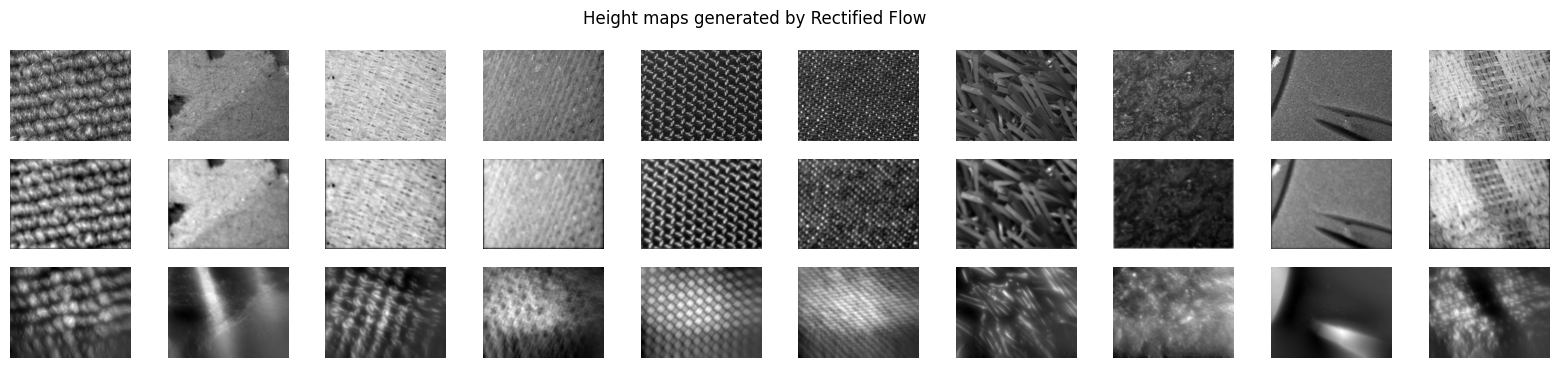

In [10]:
num_samples = 10

@torch.no_grad()
def sample_images(model, image):
    xT = image
    xT = xT.to(device)
    # xT = torch.randn_like(xT) * 0.5 + xT * 0.5
    
    # 定义时间序列 t，从 1 到 0（逆向积分）
    t = torch.linspace(1., 0., 16).to(device)  # 时间步
    
    # 需要扩展 xT 为 [num_samples, 784]，每个样本的初始噪声是独立的
    # 在 odeint 中，t 会被自动广播为 [num_samples, num_steps]
    # 使用 lambda 表达式在每个时间步计算 v_theta(x, t)
    x0_hat = odeint(lambda t, x: model(x, torch.tensor([t]).to(device)), xT, t) 
    # 取最后一步 t=0 的结果（即最终生成的样本）
    x0_hat = x0_hat[-1].cpu().detach()
    
    # 反归一化到 [0,1]
    x0_hat = (x0_hat + 1) / 2
    x0_hat = x0_hat.squeeze(0).permute(1, 2, 0).numpy()
    return x0_hat

dataloader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
(image, heightmap) = next(iter(dataloader))
image, heightmap = image.to(device), heightmap.to(device)

unet.load_state_dict(torch.load('RectifiedUNet.ckpt'))
unet.eval()

# 可视化采样结果
fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 2, 4))
for i in range(num_samples):
    axes[0][i].imshow(image[i].permute(1, 2, 0).cpu().numpy(), cmap="gray")
    axes[0][i].axis("off")
    axes[1][i].imshow(sample_images(unet, image[i].unsqueeze(0)), cmap="gray")
    axes[1][i].axis("off")
    axes[2][i].imshow(heightmap[i].permute(1, 2, 0).cpu().numpy(), cmap="gray")
    axes[2][i].axis("off")
plt.suptitle("Height maps generated by Rectified Flow")
plt.show()
